# Notebook for Combining Datasets and Models Building

In this notebook, we first select useful variables and combine all the datasets together from individual dataset analysis notebooks. We then perform cross dataset EDA on the combined dataset and visualize interesting findings. The EDA within each individual datasets are detailed in separate notebooks. Finally, we conduct the data modeling and evaluate the results.

**What type of machine learning problem are you investigating?**

In this notebook, we use machine learning techniqes to address a prediction problem on Alameda County Air Quality Index (AQI). We want to investigate what factors that inflences AQI and use these factors to build a model to predict future AQI based on data that can be collected in the past.

**What model do you plan on using and why?**

AQI is an indicater index of air pollution level. Air quality at any given time is an cummulative result of factors that's taken place in the past, including but not limited to previous air quality, climate, etc. Due to the cummulative nature of our goal parameter, we want to choose a model that can iteratively take into acount of the information of the past period of time. Thus we choose to use sliding window approach to carve out data from a chosed period of time, and implement several models including multiple linear regression and random forest to make prediction on future AQI.

In [1]:
import pandas as pd
import numpy as np
import re
import os
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd
import copy as cp
import os
import requests, zipfile, io
import warnings
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate
from sklearn.linear_model import RidgeCV, LassoCV,ElasticNetCV
from sklearn.metrics import mean_squared_error,explained_variance_score,mean_absolute_error,r2_score

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)

In [2]:
air_quality = pd.read_csv('us_air_quality_measures.csv', ',')
daily_global_weather = pd.read_csv('daily_global_weather_2020.csv', ',')

In [3]:
import sys
!{sys.executable} -m pip install reverse_geocoder

# Part 1: Combining Datasets and Analysis

In part 1, We start by loading the global weather and AQI datasets that have been analyzed in seperate notebooks. Along the way, we explore the correlation between variables and include useful plots for seeing the relationships.

**How do you engineer the features for your model? Whare are the rationales behind selecting these features?**

We select the following feature by looking up what factors influence air quality in real life. Our model aim in predicting the AQI in the Alameda County with the granularity of days. Since all the index are numerical variables while they are not in the same scale, we normalize the parameters to construct final features. Since our project focuses on a specific county Alameda, we choose to work with daily dataset to reach smaller granularity. 

## Global Weather Dataset

In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import reverse_geocoder as rg

pd.set_option('mode.chained_assignment', None)

print(daily_global_weather["Unnamed: 0"].unique() == daily_global_weather.index.to_list())
daily_global_weather_new = daily_global_weather.drop(columns=["Unnamed: 0"])
daily_global_weather_new.head()


daily_global_weather_US = daily_global_weather_new[daily_global_weather_new["Station"].str[0:2] == "US"]
daily_global_weather_US.head()


daily_global_weather_US.loc[:, "TEMP_C"] = daily_global_weather_US.loc[:, "TAVG"] / 10.0

daily_global_weather_US["Datetime"] = pd.to_datetime(daily_global_weather_US["Date"], format="%Y-%m-%d")

daily_global_weather_US.loc[:, "PRCP_Millimeter"] = daily_global_weather_US.loc[:, "PRCP"] / 10.0

daily_global_weather_US_final = daily_global_weather_US[["Station", "Latitude", "Longitude",
                                                  "Elevation", "TEMP_C", "Datetime",
                                                  "PRCP_Millimeter"]]
daily_global_weather_US_final.head()


def visualize_uni_distribution(df, name, ax, trans=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        eps = 1e-10
        sns.distplot(np.log10(df[name] + eps), ax=ax)


daily_global_weather_US_final["year"] = daily_global_weather_US_final["Datetime"].dt.year
daily_global_weather_US_final["month"] = daily_global_weather_US_final["Datetime"].dt.month
daily_global_weather_US_final["week"] = daily_global_weather_US_final["Datetime"].dt.week
daily_global_weather_US_final["day"] = daily_global_weather_US_final["Datetime"].dt.day

geo_cord = []
geo_cord = list(daily_global_weather_US_final[['Latitude', 'Longitude']].itertuples(index=False, name=None))
# use rg to search
res = rg.search(geo_cord)

states, county = [], []
for i in res:
    states.append(i["admin1"])
    county.append(i["admin2"])

daily_global_weather_US_final["state"] = states
daily_global_weather_US_final["county"] = county
daily_global_weather_US_final

[ True  True  True ...  True  True  True]
Loading formatted geocoded file...


,Station,Latitude,Longitude,Elevation,TEMP_C,Datetime,PRCP_Millimeter,year,month,week,day,state,county
2542,USS0003E03S,44.1100,-103.9800,2100.1,-0.8,2020-01-01,5.1,2020,1,1,1,South Dakota,Lawrence County
2543,USS0003E05S,44.2100,-103.7900,1868.4,1.5,2020-01-01,2.5,2020,1,1,1,South Dakota,Lawrence County
2544,USS0004E07S,44.4900,-104.4100,1801.4,1.4,2020-01-01,5.1,2020,1,1,1,Wyoming,Crook County
2545,USS0005G04S,42.4400,-105.8600,2552.7,-4.9,2020-01-01,2.5,2020,1,1,1,Wyoming,Converse County
2546,USS0005G05S,42.2800,-105.5800,2407.9,-4.2,2020-01-01,0.0,2020,1,1,1,Wyoming,Converse County
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064278,USW00094847,42.2314,-83.3308,192.3,9.6,2020-10-22,15.7,2020,10,43,22,Michigan,Wayne County
1064279,USW00094849,45.0717,-83.5644,208.5,6.7,2020-10-22,9.9,2020,10,43,22,Michigan,Alpena County
1064280,USW00094860,42.8939,-85.5447,237.1,7.7,2020-10-22,16.5,2020,10,43,22,Michigan,Kent County
1064281,USW00094908,42.3978,-90.7036,321.9,7.3,2020-10-22,36.1,2020,10,43,22,Iowa,Dubuque County


In [5]:
# select Alameda County
state_name = 'California'
weather_county = daily_global_weather_US_final[(daily_global_weather_US_final['state'] == state_name) &
                                              (daily_global_weather_US_final['county'] == 'Alameda County')]
weather_county = weather_county.groupby(['Datetime']).mean()
weather_county = weather_county.reset_index()
weather_county['Datetime'] = pd.to_datetime(weather_county['Datetime'])
weather_county

,Datetime,Latitude,Longitude,Elevation,TEMP_C,PRCP_Millimeter,year,month,week,day
0,2020-01-02,37.6542,-122.115,13.1,10.6,0.0,2020.0,1.0,1.0,2.0
1,2020-01-03,37.6542,-122.115,13.1,10.0,0.0,2020.0,1.0,1.0,3.0
2,2020-01-04,37.6542,-122.115,13.1,10.5,0.0,2020.0,1.0,1.0,4.0
3,2020-01-05,37.6542,-122.115,13.1,9.1,0.0,2020.0,1.0,1.0,5.0
4,2020-01-06,37.6542,-122.115,13.1,9.2,0.0,2020.0,1.0,2.0,6.0
...,...,...,...,...,...,...,...,...,...,...
290,2020-10-18,37.6542,-122.115,13.1,22.4,0.0,2020.0,10.0,42.0,18.0
291,2020-10-19,37.6542,-122.115,13.1,19.1,0.0,2020.0,10.0,43.0,19.0
292,2020-10-20,37.6542,-122.115,13.1,19.2,0.0,2020.0,10.0,43.0,20.0
293,2020-10-21,37.6542,-122.115,13.1,20.3,0.0,2020.0,10.0,43.0,21.0


**Q: How does the temperature and precipitation vary over the years?**

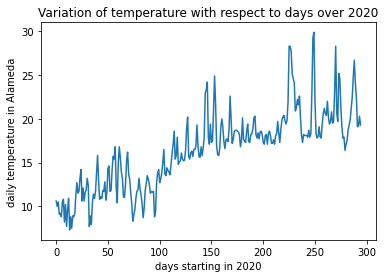

In [6]:
plt.plot(weather_county["TEMP_C"]);
plt.title("Variation of temperature with respect to days over 2020");
plt.xlabel("days starting in 2020");
plt.ylabel("daily temperature in Alameda");

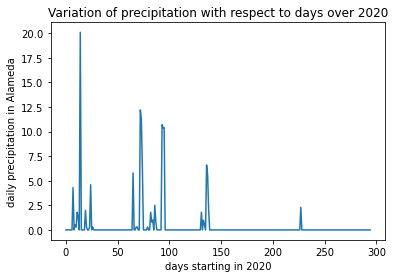

In [7]:
plt.plot(weather_county["PRCP_Millimeter"]);
plt.title("Variation of precipitation with respect to days over 2020");
plt.xlabel("days starting in 2020");
plt.ylabel("daily precipitation in Alameda");

Although the data is not whole year-round, we see that temperature is influenced by season. Similarly, the precipitation is also influenced by season. Notice that we have large amount of rain fall in spring, and that trend decreases when we get to fall.

## AQI Dataset

In [8]:
epa_weburl = "https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_co...
1,daily_county_aqi,daily_aqi_by_cou...
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


In [9]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name): 
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

In [10]:
# add month and date
daily_county = epa_data.get('daily_county_aqi')
daily_county_datetime = pd.to_datetime(daily_county['Date'])
daily_county['Month'] = pd.DatetimeIndex(daily_county_datetime).month
daily_county['day'] = pd.DatetimeIndex(daily_county_datetime).day
daily_county['Date'] = pd.to_datetime(daily_county['Date'])
AQI_county = daily_county[daily_county['county Name'] == 'Alameda']
AQI_county = AQI_county.reset_index()
AQI_county.head()

,index,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,day
0,14197,California,Alameda,6,1,2020-01-01,53,Moderate,PM2.5,06-001-0009,7,1,1
1,14198,California,Alameda,6,1,2020-01-02,43,Good,PM2.5,06-001-0013,7,1,2
2,14199,California,Alameda,6,1,2020-01-03,74,Moderate,PM2.5,06-001-0013,7,1,3
3,14200,California,Alameda,6,1,2020-01-04,45,Good,PM2.5,06-001-0007,7,1,4
4,14201,California,Alameda,6,1,2020-01-05,33,Good,PM2.5,06-001-0007,7,1,5


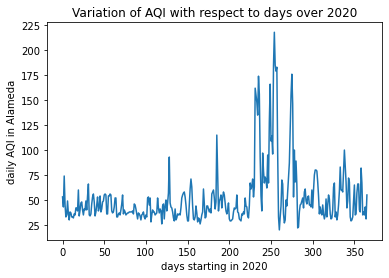

In [11]:
plt.plot(AQI_county["AQI"]);
plt.title("Variation of AQI with respect to days over 2020");
plt.xlabel("days starting in 2020");
plt.ylabel("daily AQI in Alameda");

From the above plot, we can see that there "should" be a seasonal relationship. The above plot indicates that, to capture the change in AQI, we need to gather features such as seasonal temperature and precipitation to better fit the model.

## Combine Datasets and Construct final dataframe

We first create the dataframe for using sliding windows, and then we manually add two columns - "prev_1" and "prev_2" - to do crossfeature EDA and to compare the results of using sliding windows.

Merge the dataset for sliding windows.

In [12]:
AQI_county = daily_county[daily_county['county Name'] == 'Alameda']
data_merged = pd.merge(AQI_county, weather_county, left_on='Date', right_on='Datetime')
data_final_sliding_window = data_merged[['Date', 'AQI', 'TEMP_C', 'PRCP_Millimeter']]
data_final_sliding_window = data_final_sliding_window.drop(columns=['Date'])
data_final_sliding_window['daily delta AQI'] = 0
data_final_sliding_window['daily delta AQI'][1:] = np.array(data_final_sliding_window['AQI'][1:]) - np.array(data_final_sliding_window['AQI'][:-1])
data_final_sliding_window
# normalize dataset
final_df_normalized_sw = (data_final_sliding_window.iloc[:, :] - np.mean(data_final_sliding_window.iloc[:, :], axis=0)) / np.std(data_final_sliding_window.iloc[:, :], axis=0)
final_df_normalized_sw
# retrieve the ys
final_df_normalized_with_y_sw = final_df_normalized_sw.copy()
final_df_normalized_with_y_sw = final_df_normalized_with_y_sw[["TEMP_C", "PRCP_Millimeter", "daily delta AQI", "AQI"]]
final_df_normalized_with_y_sw["target_AQI"] = data_final_sliding_window["AQI"]
final_df_normalized_with_y_sw

,TEMP_C,PRCP_Millimeter,daily delta AQI,AQI,target_AQI
0,-1.305771,-0.221391,-0.001968,-0.298223,43
1,-1.441025,-0.221391,1.634106,0.674058,74
2,-1.328313,-0.221391,-1.532489,-0.235495,45
3,-1.643905,-0.221391,-0.635287,-0.611862,33
4,-1.621363,-0.221391,0.103585,-0.549134,35
...,...,...,...,...,...
290,1.354218,-0.221391,0.156362,0.266327,61
291,0.610323,-0.221391,-0.635287,-0.110039,49
292,0.632865,-0.221391,-0.160298,-0.204131,46
293,0.880830,-0.221391,0.367468,0.015416,53


In [13]:
# select Alameda County
AQI_county = daily_county[daily_county['county Name'] == 'Alameda']
data_merged = pd.merge(AQI_county, weather_county, left_on='Date', right_on='Datetime')
data_final = data_merged[['Date', 'AQI', 'TEMP_C', 'PRCP_Millimeter']]
data_final['prev_1'] = data_final.AQI.shift(1)
data_final['prev_2'] = data_final.AQI.shift(2)
data_final = data_final.dropna()
data_final

,Date,AQI,TEMP_C,PRCP_Millimeter,prev_1,prev_2
2,2020-01-04,45,10.5,0.0,74.0,43.0
3,2020-01-05,33,9.1,0.0,45.0,74.0
4,2020-01-06,35,9.2,0.0,33.0,45.0
5,2020-01-07,49,8.8,0.0,35.0,33.0
6,2020-01-08,36,10.5,0.0,49.0,35.0
...,...,...,...,...,...,...
290,2020-10-18,61,22.4,0.0,58.0,42.0
291,2020-10-19,49,19.1,0.0,61.0,58.0
292,2020-10-20,46,19.2,0.0,49.0,61.0
293,2020-10-21,53,20.3,0.0,46.0,49.0


In [14]:
# drop Date column
data_final = data_final.drop(columns=['Date'])

Then we normalize the features.

In [15]:
final_df_normalized = (data_final.iloc[:, :] - np.mean(data_final.iloc[:, :], axis=0)) / np.std(data_final.iloc[:, :], axis=0)
final_df_normalized
# retrieve the ys
final_df_normalized_with_y = final_df_normalized.copy()
final_df_normalized_with_y = final_df_normalized_with_y[["TEMP_C", "PRCP_Millimeter", "prev_1", "prev_2"]]
final_df_normalized_with_y["AQI"] = data_final["AQI"]
final_df_normalized_with_y

,TEMP_C,PRCP_Millimeter,prev_1,prev_2,AQI
2,-1.341833,-0.222182,0.671018,-0.297000,45
3,-1.658403,-0.222182,-0.235587,0.671984,33
4,-1.635790,-0.222182,-0.610734,-0.234485,35
5,-1.726239,-0.222182,-0.548210,-0.609575,49
6,-1.341833,-0.222182,-0.110538,-0.547060,36
...,...,...,...,...,...
290,1.349010,-0.222182,0.170822,-0.328258,61
291,0.602810,-0.222182,0.264609,0.171863,49
292,0.625422,-0.222182,-0.110538,0.265636,46
293,0.874155,-0.222182,-0.204325,-0.109455,53


## Cross-Feature Exploratory Data Analysis

### Exploration 1: Relationship of variables we gathered to AQI

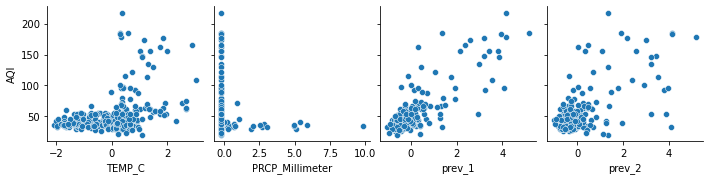

In [16]:
sns.pairplot(final_df_normalized_with_y,
            x_vars=["TEMP_C", "PRCP_Millimeter", "prev_1", "prev_2"],
            y_vars=["AQI"]);

The TEMP_C is a relatively good predictor, as it has a positive linear relationship. But the PRCP_Millimeter is not a strong predictor, because when we have little precipitation, the AQI varies a lot. Judging by the trend for the yesterday's (prev_1) and the day before yesterday's AQI (prev_2), we will definitely include those in the final model, as we assume that the environment will not have a extreme change and consequently it is reasonable to use AQI value in past few days to predict today's AQI.

### Exploration 2: Relationship of features with respect to each other

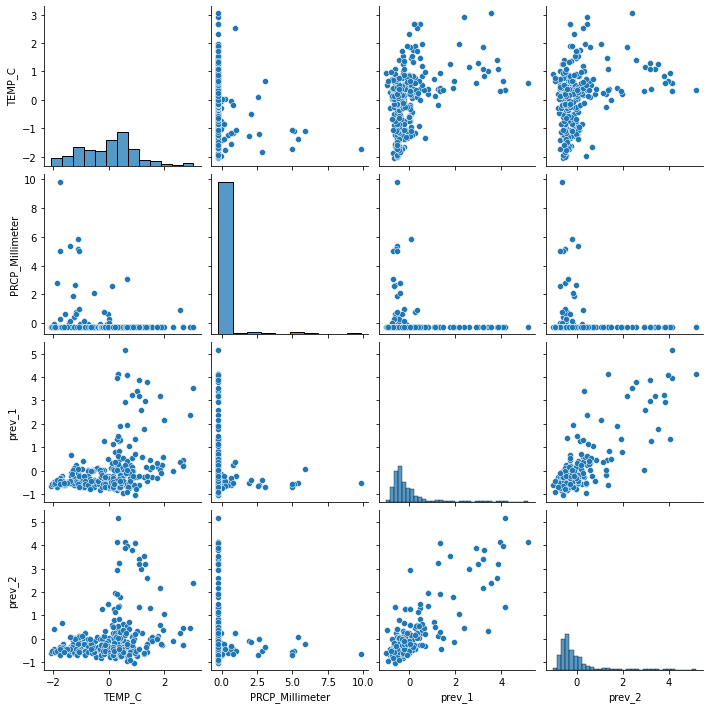

In [17]:
sns.pairplot(final_df_normalized_with_y,
            x_vars=["TEMP_C", "PRCP_Millimeter", "prev_1", "prev_2"],
            y_vars=["TEMP_C", "PRCP_Millimeter", "prev_1", "prev_2"]);

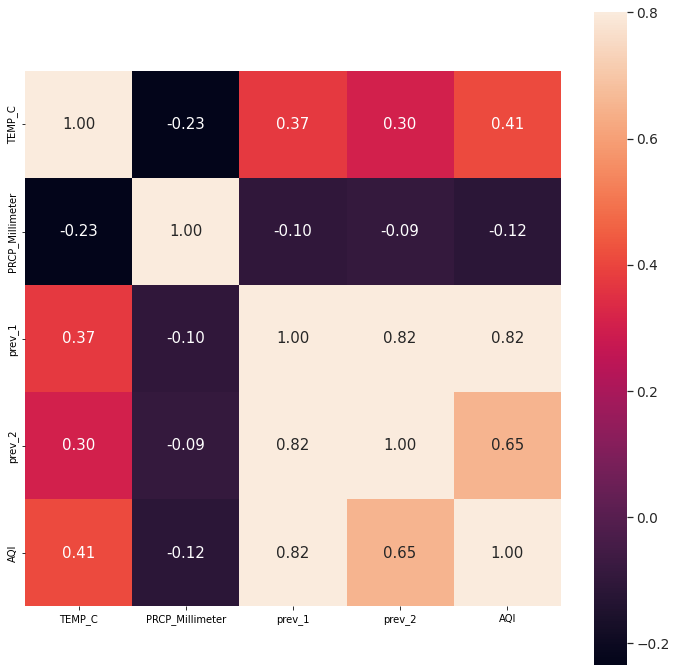

In [18]:
corrmat = final_df_normalized_with_y.corr()
fig, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=.8, annot=True, square=True, annot_kws={'size': 15}, fmt='.2f')
plt.show()

We can see that prev_1 and prev_2 are highly correlated. So, essentially we can use one column to reach the same effect as the other column. Also from the above two explorations, we can see that there are variables that are not too helpful with the regression task such as precipitation.

# Modeling

## Construct window slider

In [19]:
class WindowSlider(object):
# referenced from: https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe    
    
    def __init__(self, window_size):        
        '''
        Window Slider object
        ====================
        w: window_size - number of time steps to look back
        o: offset between last reading and temperature
        r: response_size - number of time steps to predict
        l: maximum length to slide - (#observation - w)
        p: final predictors - (#predictors * w)
        '''
        self.w = window_size
        self.o = 0
        self.r = 1       
        self.l = 0
        self.p = 0
        self.names = []
        
    def re_init(self, arr):
        
        arr = np.cumsum(arr)
        return arr - arr[0]
                

    def collect_windows(self, X, window_size, offset=0, previous_y=False):
        
        cols = len(list(X)) - 1
        N = len(X)
        
        self.o = offset
        self.w = window_size
        self.l = N - (self.w + self.r) + 1
        if not previous_y: self.p = cols * (self.w)
        if previous_y: self.p = (cols + 1) * (self.w)
        
        # Create the names of the variables in the window
        # Check first if we need to create that for the response itself
        if previous_y: x = cp.deepcopy(X)
        if not previous_y: x = X.drop(X.columns[-1], axis=1)  
        
        for j, col in enumerate(list(x)):        
                
            for i in range(self.w):
                
                name = col + ('(%d)' % (i+1))
                self.names.append(name)
        
        # Incorporate the timestamps where we want to predict
        for k in range(self.r):
            
            name = '∆t' + ('(%d)' % (self.w + k + 1))
            self.names.append(name)
            
        self.names.append('Y')
                
        df = pd.DataFrame(np.zeros(shape=(self.l, (self.p + self.r + 1))), 
                          columns=self.names)
        
        # Populate by rows in the new dataframe
        for i in range(self.l):
            
            slices = np.array([])
            
            # Flatten the lags of predictors
            for p in range(x.shape[1]):
            
                line = X.values[i:self.w + i, p]
                # Reinitialization at every window for ∆T
                if p == 0: line = self.re_init(line)
                    
                # Concatenate the lines in one slice    
                slices = np.concatenate((slices, line)) 
 
            # Incorporate the timestamps where we want to predict
            line = np.array([self.re_init(X.values[i:i+self.w+self.r, 0])[-1]])
            y = np.array(X.values[self.w + i + self.r - 1, -1]).reshape(1,)
            slices = np.concatenate((slices, line, y))
            
            # Incorporate the slice to the cake (df)
            df.iloc[i,:] = slices
            
        return df

## Utilities

In [20]:
def evaluate_rmse(y, y_pred, model_name, status, suppress=False):
    # sanity check
    assert len(y) == len(y_pred)
    rmse = np.sqrt(np.sum(np.power(y_pred - y,2)) / len(y_pred - y))
    if not suppress:
        print('%s RMSE of %s = %.2f' % (status, model_name, rmse))
    return rmse

In [21]:
def eval_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance:")
    print("--------------------------")
    print(f"R2_score \t: {R2_score}")
    print(f"MAE \t\t: {mae}")
    print(f"MSE \t\t: {mse}")
    print(f"RMSE \t\t: {rmse}")

In [22]:
def plot_y_and_ypred(train_df, y_train, y_train_pred, test_df, y_test, y_test_pred, model_name):
    fig, axs = plt.subplots(1,2, figsize=(24,6))
    plot_train_df = train_df.copy()
    plot_test_df = test_df.copy()
    
    plot_train_df['y_pred'] = y_train_pred
    plot_test_df['y_pred'] = y_test_pred
    if "AQI" in plot_train_df.columns:
        axs[0].plot(plot_train_df["AQI"], label = 'AQI')    
        axs[0].plot(plot_train_df["y_pred"], label = 'pred')
        axs[0].legend()
        axs[0].set_xlabel("days");
        axs[0].set_ylabel("daily AQI");
        axs[0].set_title("y and y_pred on training set");
        
        axs[1].plot(plot_test_df["AQI"], label = 'AQI')
        axs[1].plot(plot_test_df["y_pred"], label = 'pred')
        axs[1].legend()
        axs[1].set_xlabel("days");
        axs[1].set_ylabel("daily AQI");
        axs[1].set_title("y and y_pred on testing set");
        
    else:
        axs[0].plot(plot_train_df["Y"], label = 'Y')
        axs[0].plot(plot_train_df["y_pred"], label = 'pred')
        axs[0].legend()
        axs[0].set_xlabel("days");
        axs[0].set_ylabel("daily AQI");
        axs[0].set_title("y and y_pred on training set using sliding window");
    
        axs[1].plot(plot_test_df["Y"], label = 'Y')
        axs[1].plot(plot_test_df["y_pred"], label = 'pred')
        axs[1].legend()
        axs[1].set_xlabel("days");
        axs[1].set_ylabel("daily AQI");
        axs[1].set_title("y and y_pred on testing set using sliding window");
    
    # formatting
    plt.suptitle("Actual and predicted AQI values using %s" % model_name);

## Train Test Split

In [23]:
split_point = int(0.8 * final_df_normalized_with_y.shape[0])
tn = final_df_normalized_with_y.iloc[0:split_point, :]
vd = final_df_normalized_with_y.iloc[split_point+1:, :]

In [24]:
split_point_sw = int(0.8 * final_df_normalized_with_y_sw.shape[0])
tn_sw = final_df_normalized_with_y_sw.iloc[0:split_point_sw, :]
vd_sw = final_df_normalized_with_y_sw.iloc[split_point_sw+1:, :]

In [25]:
shuffle=False

if shuffle:
    np.random.seed(1)
    # shuffle the training set
    train_indicies = tn.index.to_list()
    # random shuffle the sequence
    np.random.shuffle(train_indicies)

    # apply the same shuffled sequence to both training data and training labels
    train_shuffled = tn.loc[train_indicies, :]

    shuffled_data = train_shuffled.iloc[:, :-1]
    shuffled_labels = train_shuffled.iloc[:, -1]
else:
    shuffled_data = tn.iloc[:, :-1]
    shuffled_labels = tn.iloc[:, -1]    

**Q: Does your model require hyperparameter tuning?**

Yes. As we use sliding window and have proposed multiple linear regression and random forest regression, it is evident that each model requires different level of hyperparameter tuning. For every model, we will tune the sliding window size and then, depending on the model, we have different model-dependent parameters to tune:

For linear regression with L2 penality, we tune the alpha parameter. For random forest regression, we tune for the number of trees in forest, the proportion of samples to be used in each tree, and the proportion of features to be used in each split.

**Q: How do you perform cross validation on your model?**

For every model, we always tune on the training set, spliting it k folds, using every k-1 folds for training the model on that set of parameters and then use the remaining 1 fold for validation. We repreat this process k times for each set of parameters. Because we are handling a regression problem, we use RMSE as the evaluation metric. The lower the RMSE, the better fit in our case. Finally, we use the best tuned parameters to construct the final model, train on the training set and evaluate on the test set.

**Q: What loss metrics are you using to evaluate your model?**

By taking some preliminary experiments, we are using root mean squared error as the loss metric. Since this is a regression task and we are fitting to the AQI curve, a good fitting curve would produce a small RMSE and we want to penalize bad predictions that are way off from the curve. Meanwhile, we also calculate MAE and r^2 to supplement our judgment.

**Q: From a bias-variance tradeoff standpoint, how do you assess the performance of your model? How do you check if it is overfitting?**

In general, based on the EDA and the visulization of the training data (as shown below in later sections), we see oscillation and some level of noise in the data. So, we don't want our models to overfit to the noise in the training set, and we control that with the use of l2 penality. Since we believe the existing features we engineered could get a good fit with a rmse near 30. we set our goal to minimize the test rmse to that standard.

For the bias-variance tradeoff, we can use the best tuned model and run it several times to evaluate the variance and bias. Some helpful plots in the following sections can be used to visualize the predicted y and the actual y for both training and test sets. If the model is overfitting, we would see a completely overlapped curve for training, but the test graph could not grasp the trend.

**Q: How would you improve your model based on the outcome?**

We use cross validation to find the best performing model parameters. To improve the model, we consider two things:

1.Use a polynomial lifting map to lift the features into a high dimensional space that contains non-linearity, since we are not using polynomial features to empower the models to model the oscillation and non-linearity in the AQI trend.

2.Use more data. We fully used 2020's data as training and test set. If we have a wider range of dataset such as including 2016-2019's data and predict on 2020, it is likely to see a reduction in RMSE on all models, as the amount of training examples increased (to allow the model learn more about the seasons, for example).

## Multiple Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

class MultipleLinearRegression:
    
    def __init__(self, window_size, tn_data, vd_data, with_y_inc=False, 
                 ):
        self.window_size = window_size
        self.with_y_inc = with_y_inc
        
        if self.with_y_inc:
            self.tn_data = WindowSlider(self.window_size).collect_windows(tn_data.iloc[:,0:], previous_y=True, 
                                                          window_size=self.window_size)
            self.vd_data = WindowSlider(self.window_size).collect_windows(vd_data.iloc[:,0:], previous_y=True, 
                                                          window_size=self.window_size)
        else:
            self.tn_data = WindowSlider(self.window_size).collect_windows(tn_data.iloc[:,0:], previous_y=False, 
                                                          window_size=self.window_size)
            self.vd_data = WindowSlider(self.window_size).collect_windows(vd_data.iloc[:,0:], previous_y=False, 
                                                          window_size=self.window_size)    
                                                    
        
        self.model = LinearRegression(fit_intercept=True)
        
    def train(self): 
        self.model.fit(self.tn_data_X, self.tn_data_Y)
    
    def get_XY(self):
        return self.tn_data, self.tn_data_X, self.tn_data_Y, self.vd_data, self.vd_data_X, self.vd_data_Y
    
    def predict(self, X):
        return self.model.predict(X)
    def get_params(self):
        return self.model.coef_

In [32]:
# we tried four sliding window size to see which one has better accuracy
w_size = [1, 2, 3 ,4]

# take w = 3 for example
def sliding_window(w):
    train_constructor = WindowSlider(w)
    train_windows = train_constructor.collect_windows(tn_sw.iloc[:,0:],w, 
                                                      previous_y=False)

    test_constructor = WindowSlider(w)
    test_windows = test_constructor.collect_windows(vd_sw.iloc[:,0:],w,
                                                    previous_y=False)

    train_constructor_y_inc = WindowSlider(w)
    train_windows_y_inc = train_constructor_y_inc.collect_windows(tn_sw.iloc[:,:],w, 
                                                      previous_y=True)

    test_constructor_y_inc = WindowSlider(w)
    test_windows_y_inc = test_constructor_y_inc.collect_windows(vd_sw.iloc[:,:],w,
                                                    previous_y=True)
    return train_windows, test_windows

In [29]:
X_train=tn.iloc[:,0:-1]
X_test=vd.iloc[:,0:-1]
feature=tn.iloc[:,0:-1].columns
print (feature)
y_train=tn.iloc[:,-1]
y_test=vd.iloc[:,-1]

Index(['TEMP_C', 'PRCP_Millimeter', 'prev_1', 'prev_2'], dtype='object')


In [25]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(tn.iloc[:,:-1], tn.iloc[:,-1])

lr_y = vd['AQI'].values
lr_y_fit = lr_model.predict(tn.iloc[:,:-1])
lr_y_pred = lr_model.predict(vd.iloc[:,:-1])

lr_residuals = lr_y_pred - lr_y
lr_rmse = np.sqrt(np.sum(np.power(lr_residuals,2)) / len(lr_residuals))

eval_metrics(y_test, lr_y_pred)
eval_metrics(y_train, lr_y_fit)

Model testing performance:
--------------------------
R2_score 	: 0.60530846204608
MAE 		: 21.767752124346774
MSE 		: 938.4921183912264
RMSE 		: 30.63481872626679
Model testing performance:
--------------------------
R2_score 	: 0.6499749560593004
MAE 		: 7.760601853068219
MSE 		: 155.17089759561105
RMSE 		: 12.456761119793983


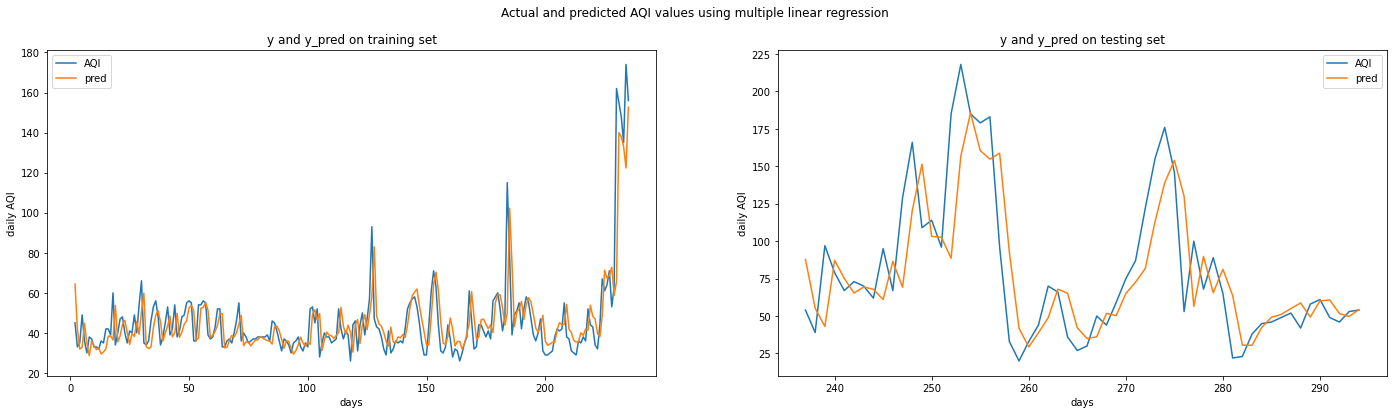

In [26]:
plot_y_and_ypred(tn, tn.iloc[:,-1], lr_y_fit, vd, vd.iloc[:,-1], 
                 lr_y_pred, "multiple linear regression")

In [33]:
for w in w_size:
    train_windows, test_windows = sliding_window(w)
train_windows

,TEMP_C(1),TEMP_C(2),TEMP_C(3),TEMP_C(4),PRCP_Millimeter(1),PRCP_Millimeter(2),PRCP_Millimeter(3),PRCP_Millimeter(4),daily delta AQI(1),daily delta AQI(2),daily delta AQI(3),daily delta AQI(4),AQI(1),AQI(2),AQI(3),AQI(4),∆t(5),Y
0,0.0,-1.441025,-2.769338,-4.413243,-0.221391,-0.221391,-0.221391,-0.221391,-0.001968,1.634106,-1.532489,-0.635287,-0.298223,0.674058,-0.235495,-0.611862,-6.034606,35.0
1,0.0,-1.328313,-2.972218,-4.593581,-0.221391,-0.221391,-0.221391,-0.221391,1.634106,-1.532489,-0.635287,0.103585,0.674058,-0.235495,-0.611862,-0.549134,-6.305113,49.0
2,0.0,-1.643905,-3.265268,-4.976800,-0.221391,-0.221391,-0.221391,-0.221391,-1.532489,-0.635287,0.103585,0.736904,-0.235495,-0.611862,-0.549134,-0.110039,-6.305113,36.0
3,0.0,-1.621363,-3.332895,-4.661208,-0.221391,-0.221391,-0.221391,-0.221391,-0.635287,0.103585,0.736904,-0.688064,-0.611862,-0.549134,-0.110039,-0.517770,-5.921895,30.0
4,0.0,-1.711532,-3.039845,-4.300532,-0.221391,-0.221391,-0.221391,1.935553,0.103585,0.736904,-0.688064,-0.318627,-0.549134,-0.110039,-0.517770,-0.705954,-6.147317,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,0.0,1.962859,3.813007,5.550444,0.932323,-0.221391,-0.221391,-0.221391,0.367468,-0.951947,0.525798,5.222914,0.579967,0.015416,0.329055,3.434082,6.566527,155.0
228,0.0,1.850148,3.587584,4.603668,-0.221391,-0.221391,-0.221391,-0.221391,-0.951947,0.525798,5.222914,-0.371404,0.015416,0.329055,3.434082,3.214535,5.687378,148.0
229,0.0,1.737436,2.753520,3.837231,-0.221391,-0.221391,-0.221391,-0.221391,0.525798,5.222914,-0.371404,-0.371404,0.329055,3.434082,3.214535,2.994988,5.146364,135.0
230,0.0,1.016084,2.099794,3.408927,-0.221391,-0.221391,-0.221391,-0.221391,5.222914,-0.371404,-0.371404,-0.688064,3.434082,3.214535,2.994988,2.587257,4.582807,174.0


In [ ]:
lr_wd_model = LinearRegression()

metrics_result = {}

for w in w_size:
    train_windows, test_windows = sliding_window(w)
    lr_wd_model.fit(train_windows.iloc[:,:-1], train_windows.iloc[:,-1])

    lr_wd_y = test_windows['Y'].values
    lr_wd_y_fit = lr_wd_model.predict(train_windows.iloc[:,:-1])
    lr_wd_y_pred = lr_wd_model.predict(test_windows.iloc[:,:-1])

    lr_wd_residuals = lr_wd_y_pred - lr_wd_y
    lr_wd_rmse = np.sqrt(np.sum(np.power(lr_wd_residuals,2)) / len(lr_wd_residuals))
    lr_wd_r2score = r2_score(lr_wd_y, lr_wd_y_pred)
    metrics_result[w] = [lr_wd_rmse, lr_wd_r2score]  

# metrics of model(size = 4)
eval_metrics(test_windows.iloc[:,-1], lr_wd_y_pred)
eval_metrics(train_windows.iloc[:,-1], lr_wd_y_fit)

Model testing performance:
--------------------------
R2_score 	: 0.5581096651367791
MAE 		: 23.206871427473825
MSE 		: 1106.3570125916833
RMSE 		: 33.26194541201226
Model testing performance:
--------------------------
R2_score 	: 0.6942923388063234
MAE 		: 7.497980102190854
MSE 		: 136.48787796160389
RMSE 		: 11.682802658677579


In [42]:
metrics_result = pd.DataFrame(metrics_result)
metrics_result.index = ['RMSE', 'R2_score']
metrics_result

,1,2,3,4
RMSE,30.568777,31.878425,33.074022,33.261945
R2_score,0.611825,0.579860,0.555012,0.558110


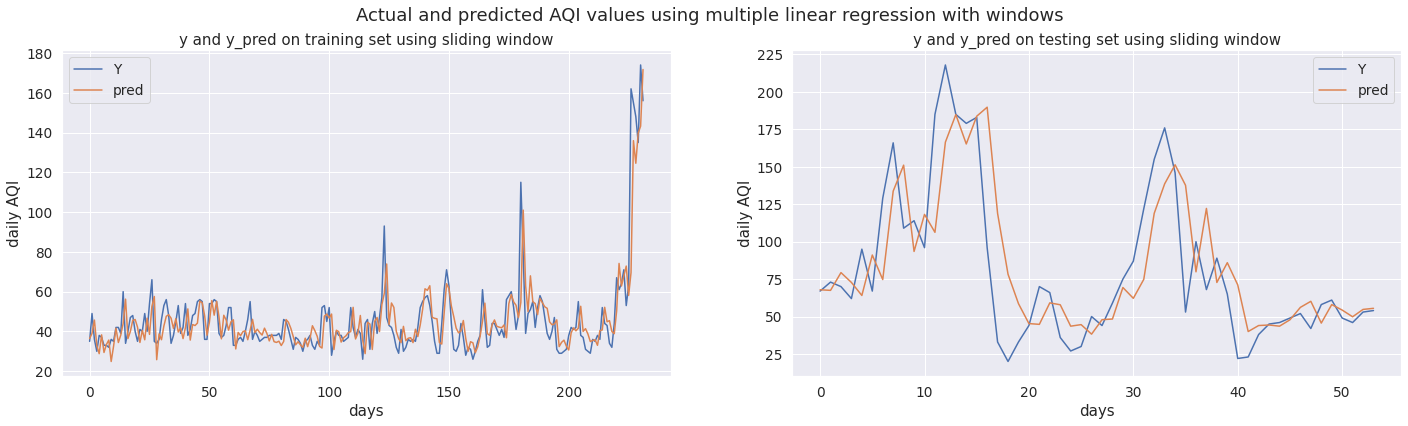

In [43]:
plot_y_and_ypred(train_windows, train_windows.iloc[:,-1], lr_wd_y_fit, test_windows, test_windows.iloc[:,-1], 
                 lr_wd_y_pred, "multiple linear regression with windows")

### Regularization - Ridge

In [31]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
eval_metrics(y_test, y_pred_ridge)

y_train_pred_ridge = ridge_model.predict(X_train)
eval_metrics(y_train, y_train_pred_ridge)

Model testing performance:
--------------------------
R2_score 	: 0.6029111128929308
MAE 		: 21.787925678912128
MSE 		: 944.1925022832296
RMSE 		: 30.727715539610646
Model testing performance:
--------------------------
R2_score 	: 0.6498392116335445
MAE 		: 7.780510713597961
MSE 		: 155.23107495935335
RMSE 		: 12.459176335510842


### Regularization - Ridge - CV

In [32]:
ridge_model = Ridge(alpha=1)
scores = cross_validate(ridge_model, X_train, y_train,
                    scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:]

,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,-1.178852,-7.674687,-97.987819,-9.898880
2,-0.585669,-8.817448,-107.558446,-10.371039
3,0.174763,-5.539836,-60.305304,-7.765649
4,-0.386956,-3.122076,-16.990216,-4.121919
5,-0.303750,-6.316045,-71.984762,-8.484383
6,0.089027,-8.838014,-159.483923,-12.628694
7,0.456807,-8.239114,-91.459801,-9.563462
8,-0.143581,-11.358337,-342.322109,-18.501949
9,0.080963,-6.918255,-69.846797,-8.357440
10,0.351485,-24.913651,-1562.493391,-39.528387


In [33]:
pd.DataFrame(scores, index = range(1, 11)).iloc[:, 2:].mean()

test_r2                              -0.144576
test_neg_mean_absolute_error         -9.173746
test_neg_mean_squared_error        -258.043257
test_neg_root_mean_squared_error    -12.922180
dtype: float64

In [34]:
alpha_space = np.linspace(0.01, 1, 100)
ridge_cv_model = RidgeCV(alphas = alpha_space, cv = 10, scoring = "neg_root_mean_squared_error")
ridge_cv_model.fit(X_train, y_train)
ridge_cv_model.alpha_
y_pred_ridge_cv = ridge_cv_model.predict(X_test)
y_train_pred_ridge_cv = ridge_cv_model.predict(X_train)
eval_metrics(y_test, y_pred_ridge_cv)
eval_metrics(y_train, y_train_pred_ridge_cv)

Model testing performance:
--------------------------
R2_score 	: 0.6052847493688512
MAE 		: 21.767807766517134
MSE 		: 938.5485020694794
RMSE 		: 30.63573896724999
Model testing performance:
--------------------------
R2_score 	: 0.6499749412740268
MAE 		: 7.760809945174726
MSE 		: 155.1709041501254
RMSE 		: 12.456761382884615


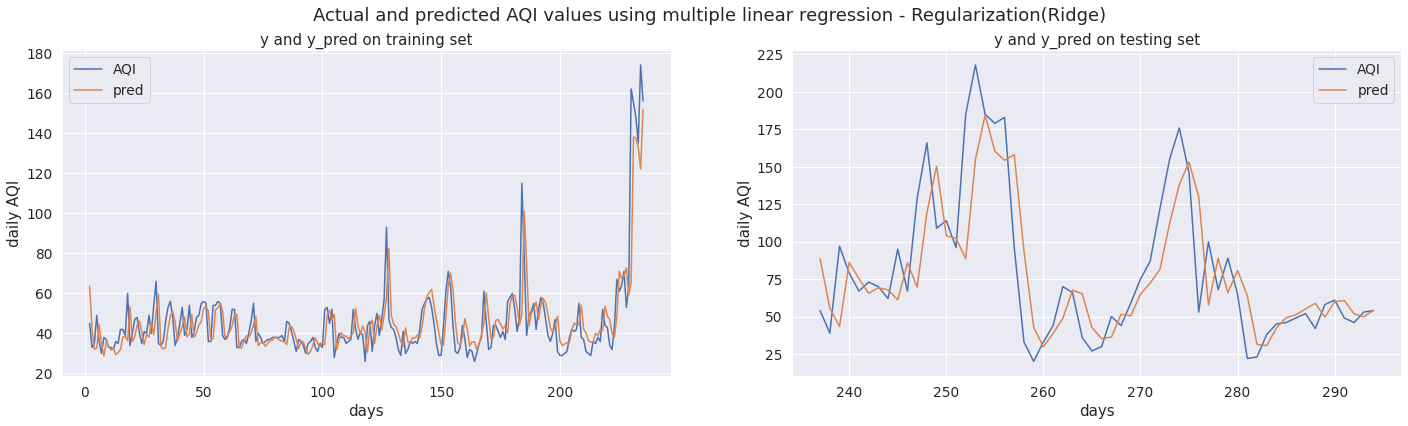

In [35]:
plot_y_and_ypred(tn, y_train, y_train_pred_ridge, vd, y_test, 
                 y_pred_ridge, "multiple linear regression - Regularization(Ridge)")

### Regularization - Lasso 

In [36]:
lasso_model = Lasso(alpha=1)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
eval_metrics(y_test, y_pred_lasso)

y_train_pred_lasso = lasso_model.predict(X_train)
eval_metrics(y_train, y_train_pred_lasso)

Model testing performance:
--------------------------
R2_score 	: 0.5930248528166404
MAE 		: 21.99025932573658
MSE 		: 967.6999157181929
RMSE 		: 31.107875461339255
Model testing performance:
--------------------------
R2_score 	: 0.6428968022616971
MAE 		: 7.716960558582126
MSE 		: 158.30874015032825
RMSE 		: 12.582080120168058


### Regularization - Lasso - CV

In [37]:
lasso_model = Lasso(alpha=1)
scores = cross_validate(lasso_model, X_train, y_train,
                    scoring=['r2', 'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index = range(1, 11))
scores.iloc[:,2:]

,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
1,-0.944796,-6.914258,-87.461818,-9.352102
2,-0.448064,-8.307622,-98.224486,-9.910827
3,0.207152,-5.433571,-57.938496,-7.611734
4,-0.009507,-2.528252,-12.366455,-3.516597
5,-0.262620,-6.259828,-69.713796,-8.349479
6,0.107651,-8.806780,-156.223534,-12.498941
7,0.530726,-7.714986,-79.013761,-8.888969
8,-0.064369,-11.073354,-318.610599,-17.849667
9,0.124007,-6.795258,-66.575493,-8.159381
10,0.029724,-30.526387,-2337.727315,-48.350050


In [38]:
pd.DataFrame(scores, index = range(1, 11)).iloc[:, 2:].mean()

test_r2                              -0.073010
test_neg_mean_absolute_error         -9.436030
test_neg_mean_squared_error        -328.385575
test_neg_root_mean_squared_error    -13.448775
dtype: float64

In [39]:
alpha_space = np.linspace(0.01, 1, 100)
lasso_cv_model = LassoCV(alphas = alpha_space, cv = 10, max_iter = 100000)
lasso_cv_model.fit(X_train, y_train)
lasso_cv_model.alpha_
y_pred_lasso_cv = lasso_cv_model.predict(X_test)
y_train_pred_lasso_cv = lasso_cv_model.predict(X_train)
eval_metrics(y_test, y_pred_lasso_cv)
eval_metrics(y_train, y_train_pred_lasso_cv)

Model testing performance:
--------------------------
R2_score 	: 0.6053609615597875
MAE 		: 21.763205814035903
MSE 		: 938.3672857685428
RMSE 		: 30.632781228098484
Model testing performance:
--------------------------
R2_score 	: 0.6499740444915456
MAE 		: 7.759053515875302
MSE 		: 155.17130170608596
RMSE 		: 12.456777340311014


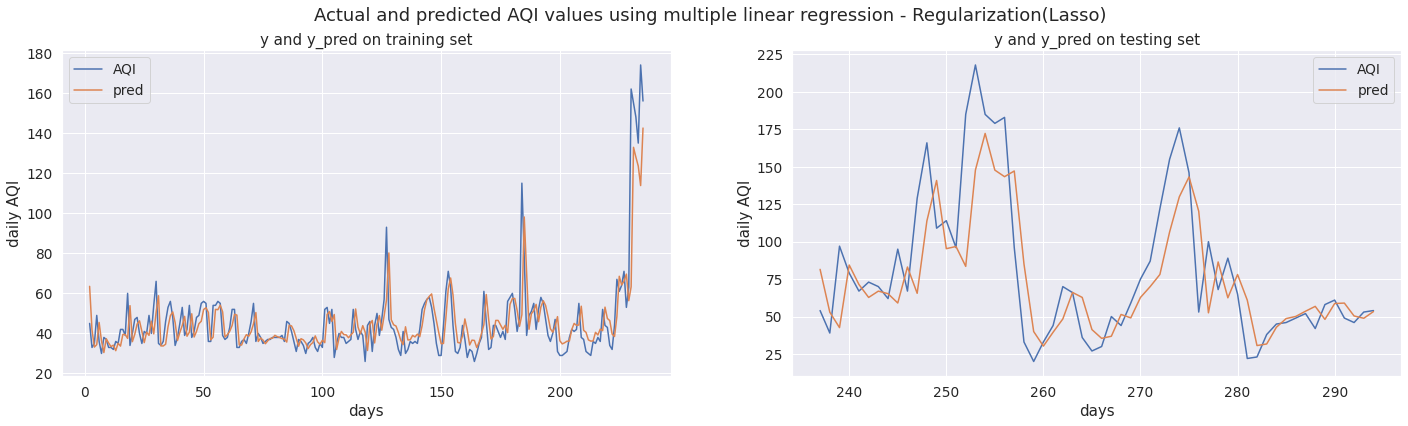

In [40]:
plot_y_and_ypred(tn, y_train, y_train_pred_lasso, vd, y_test, 
                 y_pred_lasso, "multiple linear regression - Regularization(Lasso)")

## Random Forest Regression

In [41]:
from sklearn.ensemble import RandomForestRegressor
data_train, data_test= train_test_split(final_df_normalized_with_y,test_size=0.2, random_state=0)
print ("Train set info：\n",data_train.describe().round(2))
print ("Test set info：\n",data_test.describe().round(2))
print ("Train set value：\n",data_train.iloc[:,-1].value_counts())
print ("Test set value：\n",data_test.iloc[:,-1].value_counts())

Train set info：
        TEMP_C  PRCP_Millimeter  prev_1  prev_2     AQI
count  234.00           234.00  234.00  234.00  234.00
mean    -0.06            -0.05   -0.00    0.03   52.79
std      0.95             0.81    1.03    1.04   33.12
min     -2.07            -0.22   -0.95   -1.02   20.00
25%     -0.84            -0.22   -0.52   -0.52   36.00
50%      0.13            -0.22   -0.33   -0.33   42.00
75%      0.53            -0.22    0.07    0.08   54.00
max      3.04             5.88    5.17    5.17  218.00
Test set info：
        TEMP_C  PRCP_Millimeter  prev_1  prev_2     AQI
count   59.00            59.00   59.00   59.00   59.00
mean     0.23             0.19    0.00   -0.11   51.17
std      1.15             1.54    0.89    0.83   27.42
min     -1.97            -0.22   -1.02   -0.83   28.00
25%     -0.51            -0.22   -0.49   -0.56   35.00
50%      0.29            -0.22   -0.33   -0.36   42.00
75%      0.81            -0.22    0.06    0.03   58.00
max      2.91             9.83  

In [42]:
split_point = int(0.8 * final_df_normalized_with_y.shape[0])
tn_rf = final_df_normalized_with_y.iloc[0:split_point, :]
vd_rf = final_df_normalized_with_y.iloc[split_point+1:, :]

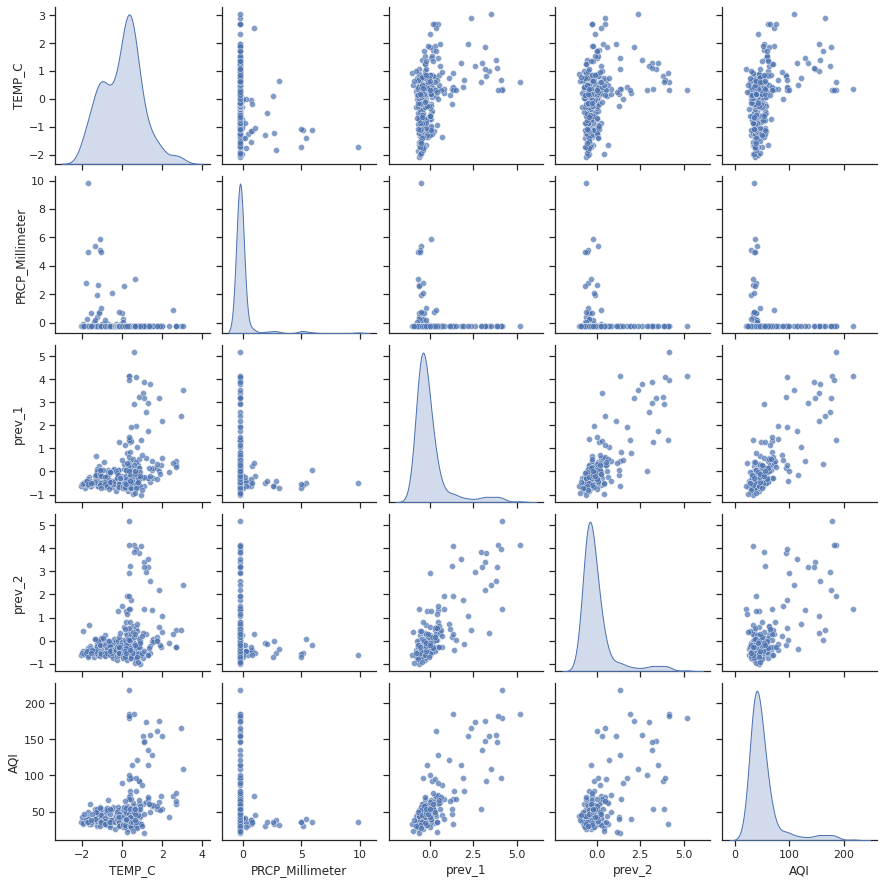

In [43]:
sns.set(style="ticks", color_codes=True);

sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

sns.pairplot(final_df_normalized_with_y, diag_kind = 'kde', plot_kws=dict(alpha = 0.7))
plt.show()

In [44]:
from sklearn.model_selection import RandomizedSearchCV
criterion=['mse','mae']
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'criterion':criterion,
                'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#build model
clf= RandomForestRegressor()
clf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                              n_iter = 10,  
                              cv = 3, verbose=2, random_state=42, n_jobs=1)
#regression
clf_random.fit(X_train, y_train)
print (clf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, criterion=mae, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, criterion=mae, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, criterion=mae, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.2s
[CV] END bootstrap=False, criterion=mae, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=166; total time=   0.6s
[CV] END bootstrap=False, criterion=mae, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=166; total time=   0.6s
[CV] END bootstrap=False, criterion=mae, max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=166; total time=   0.6s
[CV] END bootstrap=True, cr

In [45]:
rf=RandomForestRegressor(criterion='mse',bootstrap=False,max_features='sqrt', max_depth=20 ,min_samples_split=10, n_estimators=900,min_samples_leaf=2)

rf.fit(X_train, y_train) 
y_train_pred_rf=rf.predict(X_train)
y_test_pred_rf=rf.predict(X_test)

eval_metrics(y_test, y_test_pred_rf)
eval_metrics(y_train, y_train_pred_rf)

Model testing performance:
--------------------------
R2_score 	: 0.3661682174209637
MAE 		: 27.981178822295153
MSE 		: 1507.1165077923076
RMSE 		: 38.821598470340035
Model testing performance:
--------------------------
R2_score 	: 0.8532009431077994
MAE 		: 4.3339403237366065
MSE 		: 65.0780331821374
RMSE 		: 8.067095709246136


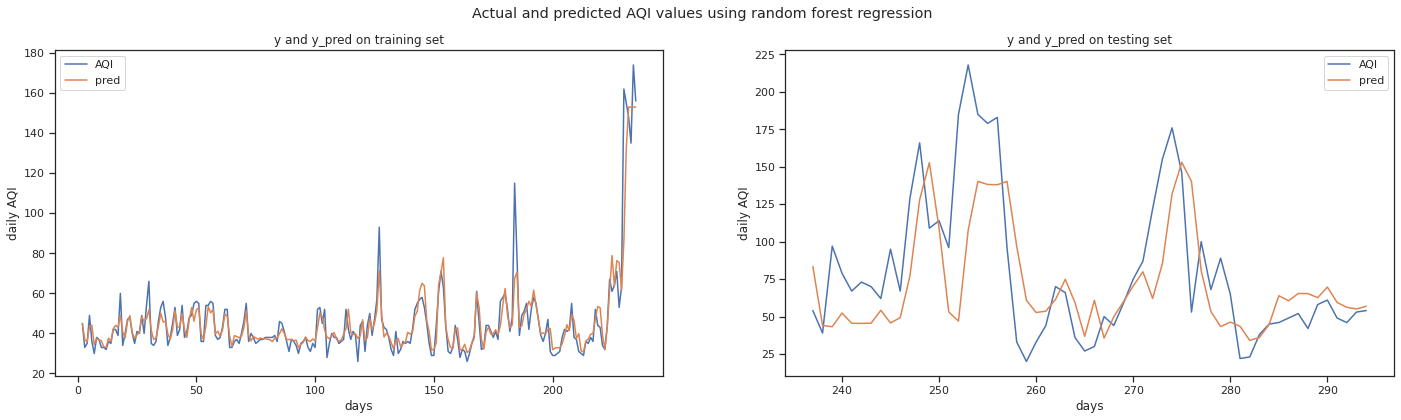

In [46]:
plot_y_and_ypred(tn_rf, tn_rf.iloc[:,-1], y_train_pred_rf, vd_rf, vd_rf.iloc[:,-1], 
                 y_test_pred_rf, "random forest regression")